# Tools for helping size UM domains

Developed by Scott Wales at CLEX

In [2]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot

def plot_region(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), rim: int=9, halo: T.Tuple[int, int]=(7,7), **kwargs):
    """
    Plots a LAM region, including its rim and halo
    """
    
    corners = draw_box_centre_size(ax, name, centre, res, size, pole, **kwargs)
    
    rim_size = [size[0]-rim*2, size[1]-rim*2]
    draw_box_centre_size(ax, name + '_rim', centre, res, rim_size, pole, ls='--', **kwargs)
    
    halo_size = [size[0]+halo[0]*2, size[1]+halo[1]*2]
    draw_box_centre_size(ax, name + '_halo', centre, res, halo_size, pole, ls=':', **kwargs)

    return corners

def draw_box_centre_size(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its centre and size
    """
    size_lon = res[1] * size[1]
    size_lat = res[0] * size[0]

    draw_box_corners(ax, name, corners=[centre[1]-size_lon/2, centre[1]+size_lon/2, centre[0]-size_lat/2, centre[0]+size_lat/2], pole=pole, **kwargs)

    return [centre[1]-size_lon/2, centre[1]+size_lon/2, centre[0]-size_lat/2, centre[0]+size_lat/2]

def draw_box_corners(ax, name: str, corners: T.Tuple[float, float, float, float], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its corners
    """
    x0,x1,y0,y1 = corners
    
    lons = numpy.linspace(x0,x1)
    lats = numpy.linspace(y0,y1)
        
    crs = ccrs.RotatedGeodetic(pole[1], pole[0])
    ax.plot(lons, [y0]*lons.size, transform=crs, **kwargs, label=name) 
    ax.plot(lons, [y1]*lons.size, transform=crs, **kwargs) 
    ax.plot([x0]*lats.size, lats, transform=crs, **kwargs) 
    ax.plot([x1]*lats.size, lats, transform=crs, **kwargs)

    

In [3]:
# Load some netcdf data to create a lat/lon grid

ERA5_wave_file = Path('/g/data/rt52/era5/single-levels/monthly-averaged/tmax/2024/tmax_era5_wamo_sfc_20240501-20240531.nc')

In [4]:
ERA5_wave = xr.open_dataset(ERA5_wave_file)
ERA5_wave

<xarray.Dataset> Size: 2MB
Dimensions:    (longitude: 720, latitude: 361, time: 1)
Coordinates:
  * longitude  (longitude) float32 3kB -180.0 -179.5 -179.0 ... 179.0 179.5
  * latitude   (latitude) float32 1kB 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * time       (time) datetime64[ns] 8B 2024-05-01
Data variables:
    tmax       (time, latitude, longitude) float64 2MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-02 07:38:20 UTC+1000 by era5_replication_tools-1.12...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels monthly-averaged period_corresponding_to...

In [5]:
# Define some grids 

CENTRE=[-37.881802,147.566895]
ERA_RES=[0.1,0.1]
ERA_SIZE=[400,470]

d1000_RES=ERA_RES
d1000_SIZE=[380,450]

d0198_RES=[0.0198,0.0198]
d0198_SIZE=[450,450]


In [6]:
#CAPE-k domain

CENTRE=[-40.8,145.3]
ERA_RES=[0.1,0.1]
ERA_SIZE=[340,420]

CAPE_K_11p1_RES=ERA_RES
CAPE_K_11p1_SIZE=[320,400]

CAPE_K_5_RES=[0.045,0.045]
CAPE_K_5_SIZE=[500,600]

CAPE_K_1_RES=[0.009,0.009]
CAPE_K_1_SIZE=[1200,1400]

# Sydney 1-km domain

SYDNEY_CENTRE=[-33.896,151.194]

SYDNEY_1_RES=[0.009,0.009]
SYDNEY_1_SIZE=[720,960]

SYDNEY_5_RES=[0.045,0.045]
SYDNEY_5_SIZE=[320,400]


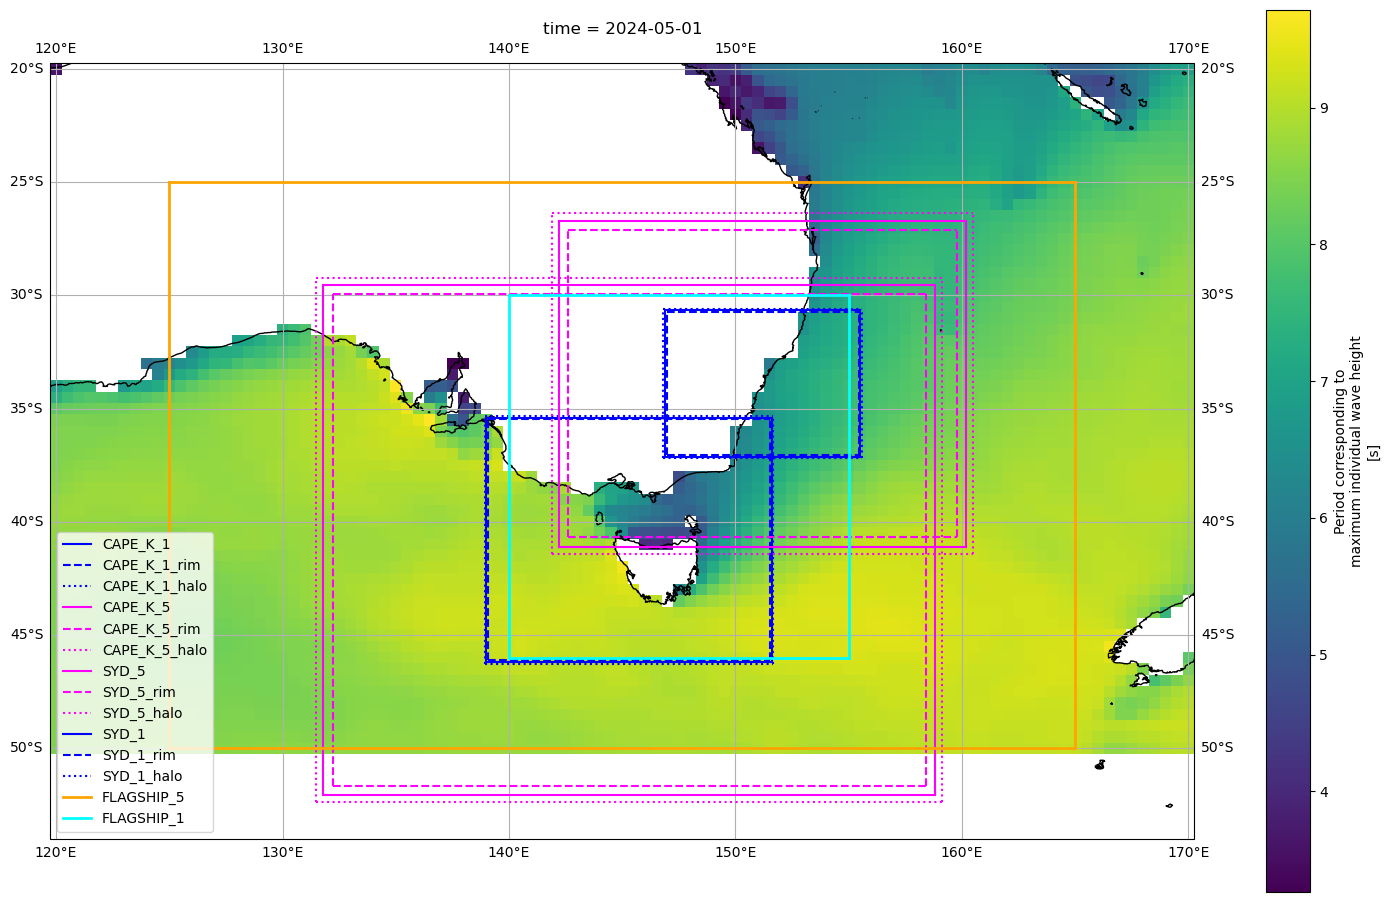

In [8]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA5_wave.tmax.sel(longitude=slice(120,170),latitude=slice(-20,-50)).plot(
    ax=ax,
    cbar_kwargs={"orientation": "vertical", "shrink": 0.6, "aspect": 20})
ax.gridlines(draw_labels=True)

cape_k_1_coords = plot_region(ax, 'CAPE_K_1', centre=CENTRE, res=CAPE_K_1_RES, size=CAPE_K_1_SIZE, color='b')
cape_k_5_coords = plot_region(ax, 'CAPE_K_5', centre=CENTRE, res=CAPE_K_5_RES, size=CAPE_K_5_SIZE, color='magenta')
syd_5_coords = plot_region(ax, 'SYD_5', centre=SYDNEY_CENTRE, res=SYDNEY_5_RES, size=SYDNEY_5_SIZE, color='magenta')
syd_1_coords = plot_region(ax, 'SYD_1', centre=SYDNEY_CENTRE, res=SYDNEY_1_RES, size=SYDNEY_1_SIZE, color='b')

draw_box_corners(ax, 'FLAGSHIP_5', corners=[125,165,-25,-50], color='orange',linewidth=2)
draw_box_corners(ax, 'FLAGSHIP_1', corners=[140,155,-30,-46], color='aqua',linewidth=2)

ax.coastlines('10m')
ax.legend(loc='lower left');
#ax.set_ylim([-38,-33])
#ax.set_ylim([145,150])
plt.tight_layout()

In [9]:
# We now return the co-ords of each region as an object when we plot, so we can determine their lat/lon bounds

print (f'{syd_1_coords}')

[146.874, 155.51399999999998, -37.136, -30.656000000000002]


In [12]:
# A simple function to return the bounds of a domain defined using the UM ancil controls CENTRE, RESOLUTION and SIZE 

def print_corners(centre,res,size):
    """
    print corners of domain for a centre, res and size
    """
    size_lon = res[1] * size[1]
    size_lat = res[0] * size[0]

    corners=[centre[1]-size_lon/2, centre[1]+size_lon/2, centre[0]-size_lat/2, centre[0]+size_lat/2]

    print (f'For {centre} with {res} and {size}: coords = {corners[0]:.3f}, {corners[1]:.3f}, {corners[2]:.3f}, {corners[3]:.3f}')



In [13]:
# We can use this to adjust the size of the Sydney 1 km domain so that it extends to -30 S.

SYDNEY_1_SIZE_B=[866,960]
print_corners(SYDNEY_CENTRE, SYDNEY_1_RES, SYDNEY_1_SIZE_B)

For [-33.896, 151.194] with [0.009, 0.009] and [866, 960]: coords = 146.874, 155.514, -37.793, -29.999


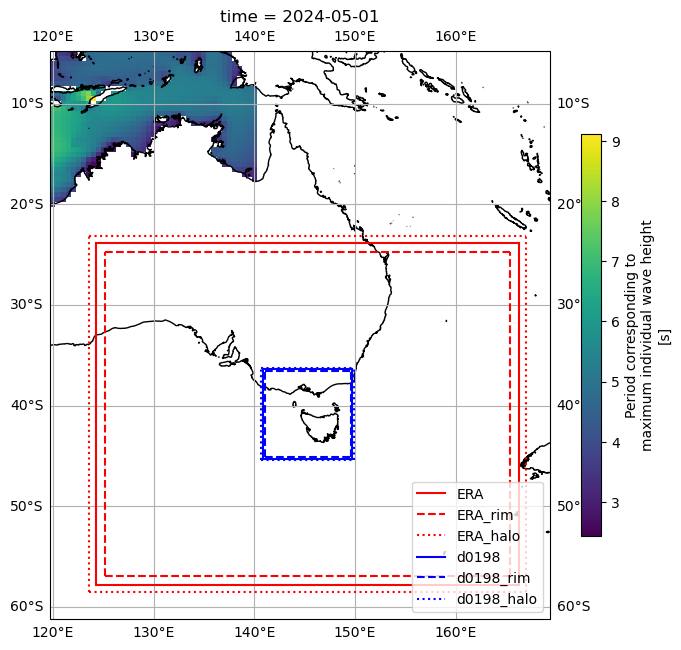

In [16]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ERA5_wave.tmax.sel(longitude=slice(120,140),latitude=slice(-5,-20)).plot(
    ax=ax,
    cbar_kwargs={"orientation": "vertical", "shrink": 0.6, "aspect": 20})
ax.gridlines(draw_labels=True)

plot_region(ax, 'ERA', centre=CENTRE, res=ERA_RES, size=ERA_SIZE, color='r')
plot_region(ax, 'd0198', centre=CENTRE, res=d0198_RES, size=d0198_SIZE, color='b')
ax.coastlines('10m')
ax.legend(loc='lower right');
plt.tight_layout()

In [17]:
CENTRE=[-27.8,133.26]
AUS2200_RES=[0.0198,0.0198]
AUS2200_SIZE=[2120,2600]

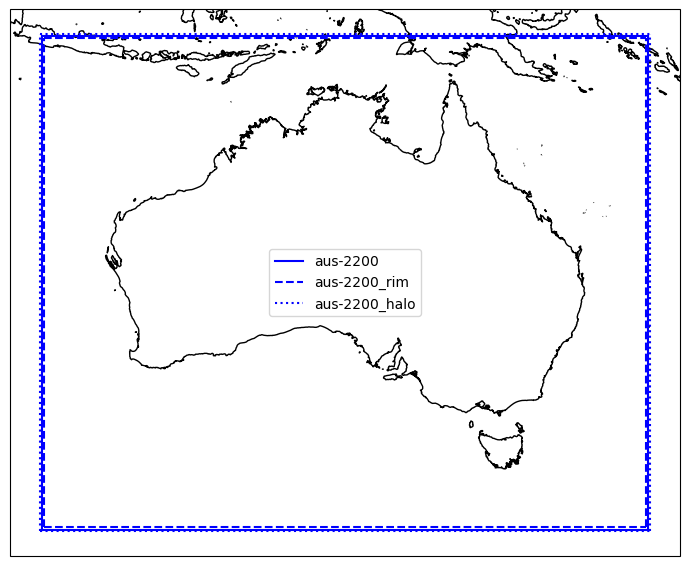

In [18]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
#ERA5_wave.tmax.sel(longitude=slice(100,200),latitude=slice(-5,-50)).plot(
#    ax=ax,
#    cbar_kwargs={"orientation": "vertical", "shrink": 0.6, "aspect": 20})
#ax.gridlines(draw_labels=True)

plot_region(ax, 'aus-2200', centre=CENTRE, res=AUS2200_RES, size=AUS2200_SIZE, color='b')
ax.coastlines('10m')
ax.legend()#loc='lower left');
plt.tight_layout()
plt.savefig('aus2200-domain.png')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


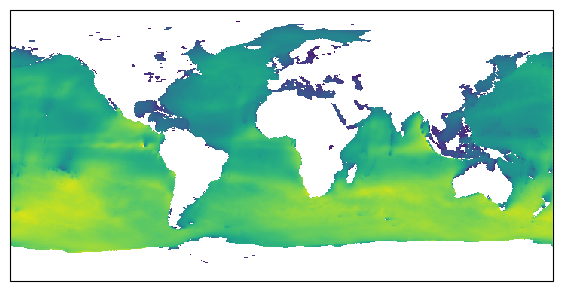

In [19]:
# Use iris
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

ERA5_cube = iris.load_cube(ERA5_wave_file)

iris.plot.pcolormesh(ERA5_cube[0], axes=ax)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/coords.py:1978: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


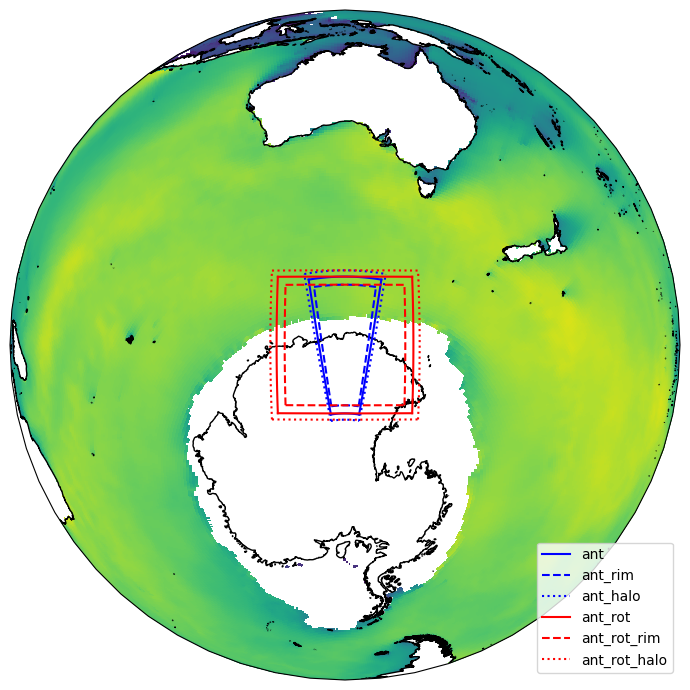

In [20]:
# Rotated pole example
CENTRE=[-68.0,130.0]
RES=[0.135,0.135]
SIZE=[150,150]
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=-68, central_longitude=130))
iris.plot.pcolormesh(ERA5_cube[0], axes=ax)
plot_region(ax, 'ant', centre=CENTRE, res=RES, size=SIZE, color='b')
plot_region(ax, 'ant_rot', centre=[0,0], res=RES, size=SIZE, pole=[90+68,180+130], color='r')

ax.set_global()
ax.coastlines('10m')
ax.legend(loc='lower right');
plt.tight_layout()

In [13]:
with open(veg_cover,'rb') as f:
    r = read_igbp(f)

In [14]:
r

{'points_lambda_srce': 43200,
 'points_phi_srce': 21600,
 'phi_origin_srce': 90.0,
 'lambda_origin_srce': 0.0,
 'delta_phi_srce': 0.00833333,
 'delta_lambda_srce': 0.00833333,
 'data': array([[32, 32, 32, ..., 82, 82, 82],
        [82, 82, 82, ..., 82, 82, 82],
        [82, 82, 82, ..., 82, 82, 82],
        ...,
        [79, 79, 79, ..., 79, 79, 79],
        [79, 79, 79, ..., 79, 79, 79],
        [79, 79, 79, ..., 82, 82, 82]], dtype=int8)}

In [15]:
r['data'].shape

(21600, 43200)

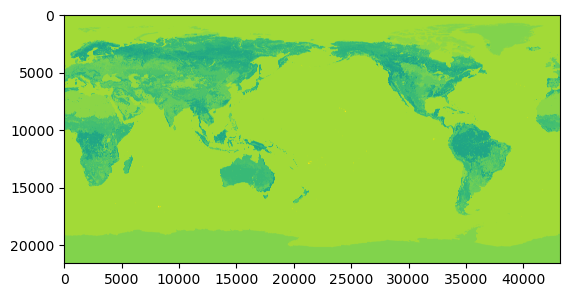

In [16]:
plt.imshow(r['data'])

[66 70 71 72 73 74 76 77 78 79 80 81 82 90]


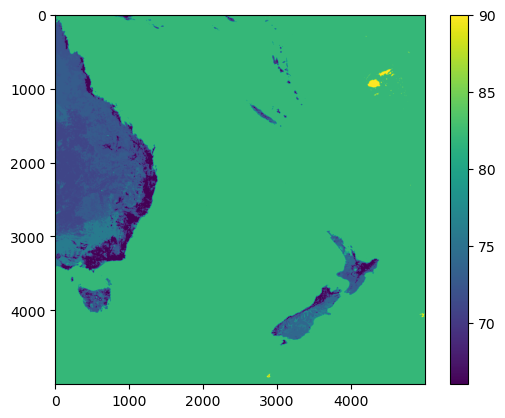

In [25]:
plt.imshow(r['data'][12000:17000,17000:22000])
plt.colorbar()
print (np.unique(r['data'][12000:17000,17000:22000]))

[66 73 74 76 77 79 81 82]


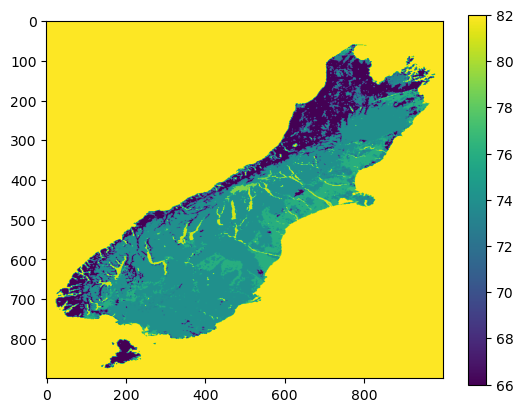

In [56]:
new_zealand_south = r['data'][15600:16500,19900:20900]
plt.imshow(new_zealand_south)
plt.colorbar()
print (np.unique(new_zealand_south))

In [31]:
x=24.2356
print (f'{x:.2f}')

24.24
